100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 38.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 45.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.19MB/s]


Epoch [1/300]  Loss D: 1.1604, Loss G: 1.7791
Epoch [2/300]  Loss D: 1.0800, Loss G: 1.1292
Epoch [3/300]  Loss D: 0.8321, Loss G: 0.7459
Epoch [4/300]  Loss D: 0.8624, Loss G: 1.6968
Epoch [5/300]  Loss D: 0.7776, Loss G: 1.4245
Epoch [6/300]  Loss D: 0.8065, Loss G: 1.5521
Epoch [7/300]  Loss D: 0.7348, Loss G: 1.3424
Epoch [8/300]  Loss D: 1.7012, Loss G: 2.1935
Epoch [9/300]  Loss D: 0.6940, Loss G: 1.9152
Epoch [10/300]  Loss D: 0.7783, Loss G: 1.7576
Epoch [11/300]  Loss D: 0.7843, Loss G: 1.4478
Epoch [12/300]  Loss D: 0.7610, Loss G: 1.3213
Epoch [13/300]  Loss D: 0.6732, Loss G: 1.5345
Epoch [14/300]  Loss D: 0.7850, Loss G: 1.9033
Epoch [15/300]  Loss D: 0.5812, Loss G: 2.1211
Epoch [16/300]  Loss D: 0.8869, Loss G: 2.6571
Epoch [17/300]  Loss D: 0.8507, Loss G: 1.4140
Epoch [18/300]  Loss D: 0.5961, Loss G: 2.0861
Epoch [19/300]  Loss D: 0.7672, Loss G: 1.4018
Epoch [20/300]  Loss D: 0.5258, Loss G: 1.8732
Epoch [21/300]  Loss D: 0.6063, Loss G: 2.0853
Epoch [22/300]  Loss D

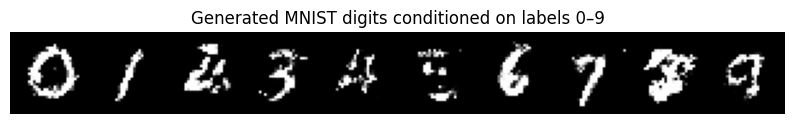

Epoch [51/300]  Loss D: 1.1005, Loss G: 0.9639


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
z_dim = 100
embedding_dim = 50
epochs = 300
lr_g = 0.0002
lr_d = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(z_dim + embedding_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat([noise, label_input], dim=1)
        x = self.fc(x)
        return x.view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(28*28 + embedding_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), label_input], dim=1)
        x = self.fc(x)
        return x

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Optimizers and loss
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Training loop
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(loader):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, 10, (batch_size,)).to(device)
        gen_imgs = G(z, gen_labels)
        real_loss = criterion(D(real_imgs, labels), valid)
        fake_loss = criterion(D(gen_imgs.detach(), gen_labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        gen_imgs = G(z, gen_labels)
        g_loss = criterion(D(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

    # Visualize generation per 50 epochs
    if (epoch+1) % 50 == 0 or epoch == epochs - 1:
        with torch.no_grad():
            test_labels = torch.arange(10).to(device)
            test_noise = torch.randn(10, z_dim).to(device)
            test_imgs = G(test_noise, test_labels)
            test_imgs = (test_imgs + 1) / 2  # denormalize

            grid = make_grid(test_imgs, nrow=10)
            plt.figure(figsize=(10, 2))
            plt.title("Generated MNIST digits conditioned on labels 0–9")
            plt.axis("off")
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()